<a href="https://colab.research.google.com/github/ChovenDV/time-series/blob/main/Laba1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.signal import periodogram
from scipy.signal import coherence
from scipy.signal import csd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
N=500
t = np.linspace(0, N, N)
a0, a1, a2 = 0.3, 0.09, 0.7
y1 = a0 * np.sin(a1 * 2 * np.pi * t) + a2 * np.random.normal(size=t.shape)
y3 = np.exp(0.005 * t) + 2 * np.random.normal(size=t.shape)

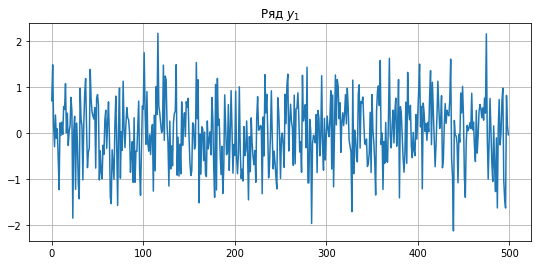

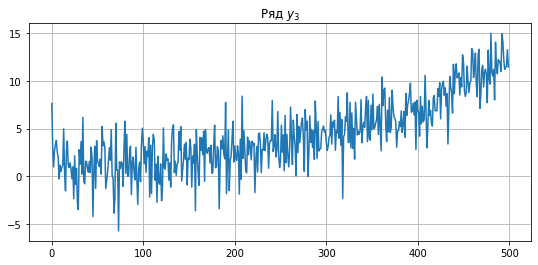

In [ ]:
def ts_plot(t_s, title=None):
    plt.figure(figsize=(9, 4))
    plt.plot(t_s)
    plt.title(title)
    plt.grid()
    plt.show()
ts_plot(y1, title='Ряд $y_1$')
ts_plot(y3, title='Ряд $y_3$')

In [ ]:
def delta(x):
    '''Функция возвращает x(t) - x(t-1), x(t+1) - x(t)'''
    return x[1:-1] - x[:-2], x[2:] - x[1:-1]


def confidance_ellipse(series):
    '''Функция нахождения эллипса рассеивания'''

    x, y = delta(series)

    # матрица корреляций
    r = np.corrcoef(x, y)[1, 0]

    # угол наклона осей эллипса
    alf = np.arctan(2 * r * x.std() * y.std() / abs(x.var() - y.var())) / 2

    # центр эллипса
    u, v = x.mean(), y.mean()

    var_x_ = x.var() * np.cos(alf) ** 2 + r * x.std() * y.std() * np.sin(2 * alf)\
             + y.var() * np.sin(alf) ** 2
    var_y_ = x.var() * np.sin(alf) ** 2 - r * x.std() * y.std() * np.sin(2 * alf)\
             + y.var() * np.cos(alf) ** 2

    # радиус его осей
    a = np.sqrt(var_x_) * np.sqrt(5.991)
    b = np.sqrt(var_y_) * np.sqrt(5.991)

    ell_params = {'u' : u,
                 'v' : v,
                 'a' : a,
                 'b' : b,
                 'alf' : alf}

    # построение
    _ = np.linspace(0, 2 * np.pi, 201)

    Ell = np.array([a * np.cos(_), b * np.sin(_)])

    Ell_rot = rotate_points(Ell, alf)
    Ell_rot[0, :] = Ell_rot[0, :] + u
    Ell_rot[1, :] = Ell_rot[1, :] + v

    return x, y, Ell_rot, ell_params


def rotate_points(points, alf):
    # матрица линейной трансформации, для поворота на необходимый угол
    R_rot = np.array([[np.cos(alf), -np.sin(alf)],
                      [np.sin(alf), np.cos(alf)]])

    points_r = np.dot(R_rot, points)

    return points_r


def find_anomalies(series):
    d_x, d_y, el, ell_params = confidance_ellipse(series)

    points_r = rotate_points(np.vstack((d_x, d_y)), -ell_params['alf'])

    dx_new, dy_new = points_r[0].copy(), points_r[1].copy()

    cnt = 0
    x_bad = []
    y_bad = []

    for i in range(len(dx_new)):
        if ((dx_new[i] - ell_params['u']) / ell_params['a']) ** 2 + ((dy_new[i] - ell_params['v']) / ell_params['b']) ** 2 > 1:
            cnt += 1
            x_bad.append(d_x[i])
            y_bad.append(d_y[i])
            series[i] = (series[i+1] + series[i-1]) / 2

    points = {
        'd_x' : d_x,
        'd_y' : d_y,
        'x_bad' : x_bad,
        'y_bad' : y_bad,
        'cnt' : cnt
    }

    ellipse = {
        'x': el[0],
        'y' : el[1]
    }

    return series, points, ellipse

def plot_confidance_ellipse(ellipse, d_x, d_y, x_bad = None, y_bad = None, title=None):

    plt.figure(figsize=(6, 6))
    plt.plot(ellipse['x'], ellipse['y'], c='g', linewidth=3)
    plt.scatter(d_x, d_y, label='Временной ряд', c='b', s=10)
    plt.title(title)

    if x_bad:
        plt.scatter(points['x_bad'], points['y_bad'], c='r', marker="*", s=30)

    plt.show()

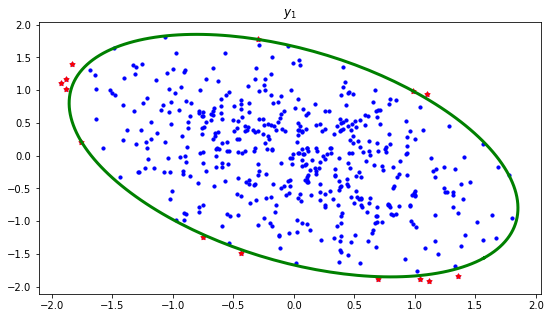

In [ ]:
plot_confidance_ellipse(ellipse, points['d_x'], points['d_y'], points['x_bad'], points['y_bad'], title='$y_1$')

In [ ]:
y3_new, points, ellipse = find_anomalies(y3)

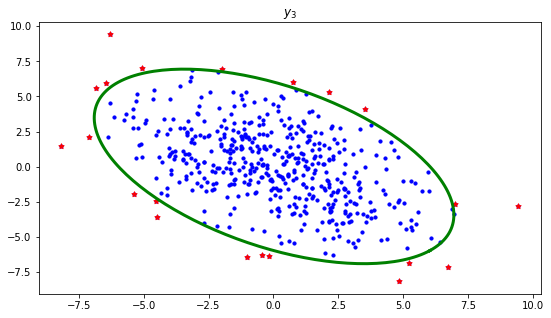

In [ ]:
plot_confidance_ellipse(ellipse, points['d_x'], points['d_y'], points['x_bad'], points['y_bad'], title='$y_3$')

Text(0.5, 1.0, '$y_3$ ряд без аномальных значений')

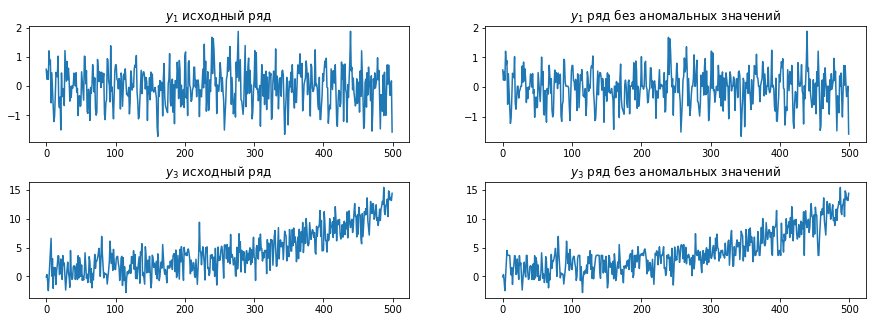

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(15,5))
plt.subplots_adjust(hspace=0.35)
ax[0][0].plot(y1)
ax[0][0].set_title('$y_1$ исходный ряд')
ax[0][1].plot(y1_n)
ax[0][1].set_title('$y_1$ ряд без аномальных значений')
ax[1][0].plot(y3)
ax[1][0].set_title('$y_3$ исходный ряд')
ax[1][1].plot(y3_n)
ax[1][1].set_title('$y_3$ ряд без аномальных значений')

In [ ]:
# Пункт 3
def v_t(t_s):
    v, t_list = 0, []
    counter, present_elem = 1, np.sign(t_s[0])
    for x in np.nditer(t_s[1:]):
        if present_elem * x >= 0:
            counter += 1
        else:
            v += 1
            t_list.append(counter)
            counter, present_elem = 1, np.sign(x)
    t_list.append(counter)
    v +=1
    return v, max(t_list)

def criterion_series(t_s):
    median = np.median(t_s)
    t_s = t_s - median
    N = t_s.size
    v, t = v_t(t_s)
    return (v > 0.5 * (N + 2 - 1.96 * (N - 1)**0.5)) and(t < 1.43 * np.log(N + 1))

def criterion_up_down(t_s):
    N = t_s.size
    t_s = t_s[1:] - t_s[:-1]
    v, t = v_t(t_s)
    if N <= 6:
        tmax = 5
    elif N <= 153:
        tmax = 6
    else:
        tmax = 7
    return v > ((2*N - 1)/3 - 1.96*((16*N-29)/90)**0.5) and t < tmax

def analysis_mean_var(t_s, plot=False):
    mean, variance = [], []
    for i in range(10):
        x = t_s[i * 50: (i + 1) * 50]
        mean.append(x.mean())
        variance.append(x.var())
    crit_series_mean = criterion_series(np.array(mean))
    crit_up_down_mean = criterion_up_down(np.array(mean))
    crit_series_var = criterion_series(np.array(variance))
    crit_up_down_var = criterion_up_down(np.array(variance))
    print('Среднее:', end='\t')
    if crit_series_mean or crit_up_down_mean:
        print('Нет тренда')
    else:
        print('Найден тренд')
    print('Дисперсия:', end='\t')
    if crit_series_var or crit_up_down_var:
        print('Нет тренда')
    else:
        print('Найден тренд')
    if plot:
        plt.plot(mean, label='Среднее')
        plt.plot(variance, label='Дисперсия')
        plt.legend()
        plt.show()


Ряд y1:
Среднее:	Нет тренда
Дисперсия:	Нет тренда


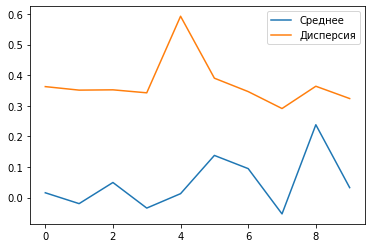


Ряд y3:
Среднее:	Найден тренд
Дисперсия:	Нет тренда


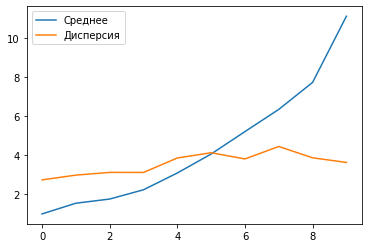

In [ ]:
print('\nРяд y1:')
analysis_mean_var(y1, plot=True)
print('\nРяд y3:')
analysis_mean_var(y3,plot=True)

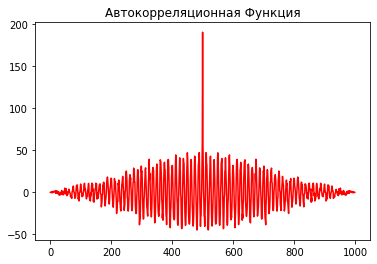

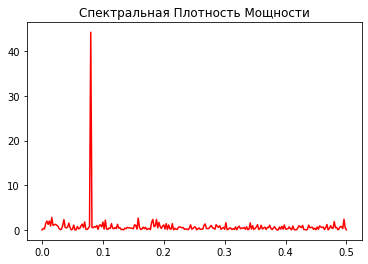

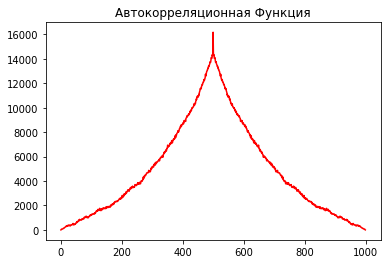

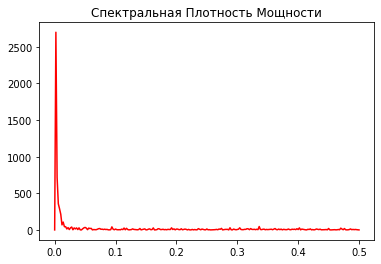

In [ ]:
# построение АКФ и СПМ
def plot_autocorr(x, ax=None):
    if ax is None:
        plt.plot(correlate(x, x), color='r')
        plt.title('Автокорреляционная Функция')
        plt.show()
    else:
        ax.plot(correlate(x, x), color='r')

def plot_periodog(x, ax=None):
    f, P_xx = periodogram(x)
    if ax is None:
        plt.plot(f, P_xx, color='r')
        plt.title('Спектральная Плотность Мощности')
        plt.show()
    else:
        ax.plot(f, P_xx, color='r')

plot_autocorr(y1)
plot_periodog(y1)
plot_autocorr(y3)
plot_periodog(y3)

Text(0.5, 1.0, 'Спектральная Плотность Мощности $y_{3}$')

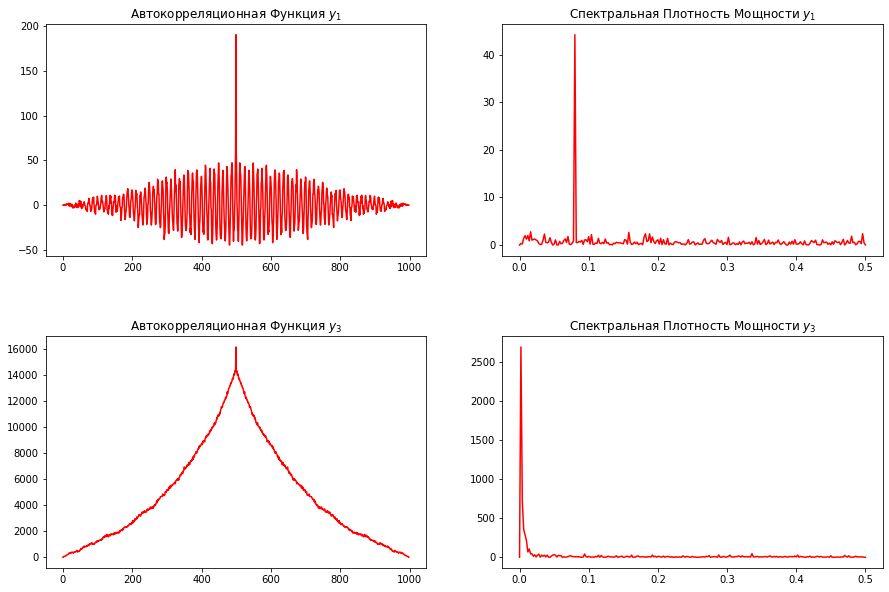

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(15,10))
plt.subplots_adjust(hspace=0.35)
plot_autocorr(y1,ax=ax[0][0])
ax[0][0].set_title('Автокорреляционная Функция $y_{1}$')
plot_periodog(y1,ax=ax[0][1])
ax[0][1].set_title('Спектральная Плотность Мощности $y_{1}$')
plot_autocorr(y3,ax=ax[1][0])
ax[1][0].set_title('Автокорреляционная Функция $y_{3}$')
plot_periodog(y3,ax=ax[1][1])
ax[1][1].set_title('Спектральная Плотность Мощности $y_{3}$')

In [ ]:
# Пункт 4
def polyfit(x, y):
    poly = PolynomialFeatures(2)
    features = poly.fit_transform(x[:, np.newaxis])
    model = LinearRegression().fit(features, y[:, np.newaxis])
    return model.coef_

def find_trend(t_s):
    coeff = polyfit(t, t_s)[0]
    new_t_s = t_s - coeff[0] - coeff[1] * t - coeff[2] * t ** 2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(t_s, label='С трендом')
    ax1.legend()
    ax2.plot(new_t_s, label='С удалением тренда')
    ax2.plot(coeff[0] + coeff[1] * t + coeff[2] * t ** 2, label='Тренд')
    ax2.legend()
    plt.show()
    fig, ax = plt.subplots(2, 2, figsize=(10, 5))
    plt.subplots_adjust(hspace=0.35)
    plot_autocorr(t_s, ax[0][0])
    ax[0][0].set_title('АКФ исходного ряда')
    plot_autocorr(new_t_s, ax[0][1])
    ax[0][1].set_title('АКФ ряда с удаленным трендом')
    plot_periodog(t_s, ax[1][0])
    ax[1][0].set_title('СПМ исходного ряда')
    plot_periodog(new_t_s, ax[1][1])
    ax[1][1].set_title('СПМ ряда с удаленным трендом')
    plt.show()
    return new_t_s

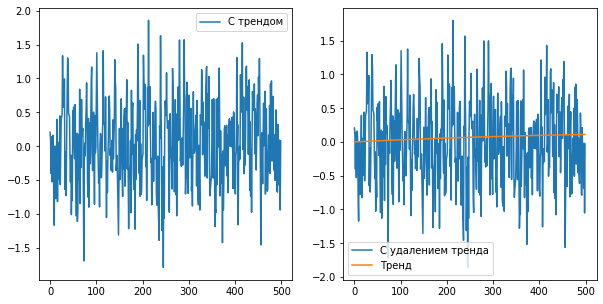

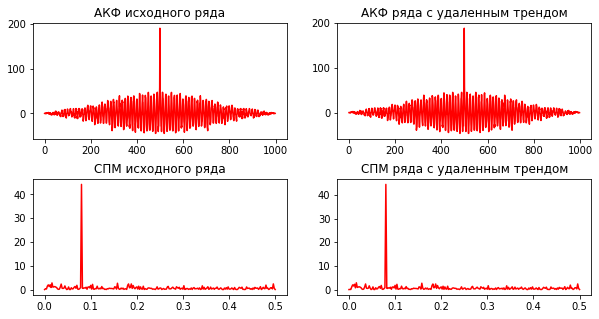

In [ ]:
y1_new = find_trend(y1)

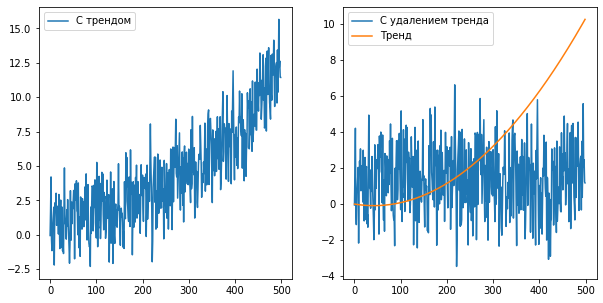

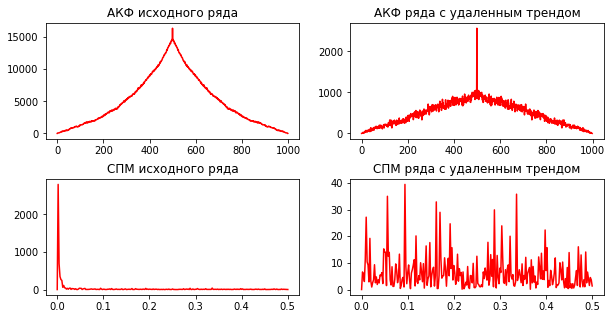

In [ ]:
y3_new = find_trend(y3)

Критерий Колмогорова-Смирнова:
y1: D = 0.12965192093760058 p = 8.684277079194544e-08
y3: D = 0.4260325648799916  p = 7.088541870124458e-83


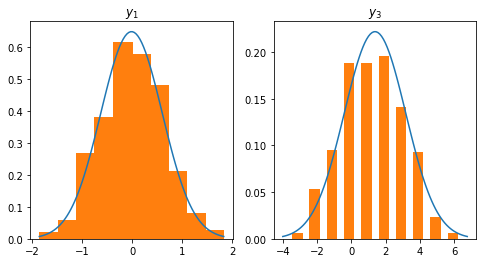

In [ ]:
from scipy import stats
mu = y1_new.mean()
sigma = y1_new.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
plt.subplots_adjust(hspace=0.35)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma))
ax[0].hist(y1_new, density=True, width=0.4)
ax[0].set_title('$y_1$')

mu = y3_new.mean()
sigma = y3_new.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[1].plot(x, stats.norm.pdf(x, mu, sigma))
ax[1].hist(y3_new, density=True, width=0.6)
ax[1].set_title('$y_3$')

print('Критерий Колмогорова-Смирнова:')
D, p = stats.kstest(y1_new, "norm")
print('y1:', 'D =', D, 'p =', p)
D, p = stats.kstest(y3_new, "norm")
print('y3:', 'D =', D, ' p =', p)

# В приведенном выше примере D обозначает расстояние между нашим data и гауссовским нормальным ( norm ) распределением
# (чем меньше, тем лучше), а p обозначает соответствующее p-значение.

In [ ]:
y3_new.var()

3.2339041522443166

Text(0.5, 1.0, 'Встроенная функция')

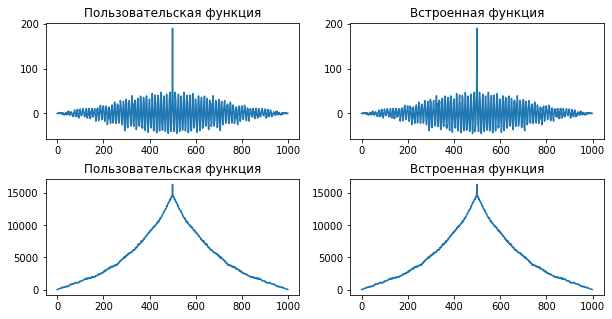

In [ ]:
# Пункт 5
def auto_correlate(x):
    N = x.size
    m_x = x.mean()
    r = []
    for i in range(-N+1, N):
        x1 = x[: N-abs(i)]
        x2 = x[abs(i):]
        _ = np.sum((x1)*(x2))
        r.append(_)
    return np.array(r)

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.35)
ax[0][0].plot(auto_correlate(y1))
ax[0][0].set_title('Пользовательская функция')
ax[0][1].plot(correlate(y1, y1))
ax[0][1].set_title('Встроенная функция')
ax[1][0].plot(auto_correlate(y3))
ax[1][0].set_title('Пользовательская функция')
ax[1][1].plot(correlate(y3, y3))
ax[1][1].set_title('Встроенная функция')

Text(0.5, 1.0, 'Встроенная функция')

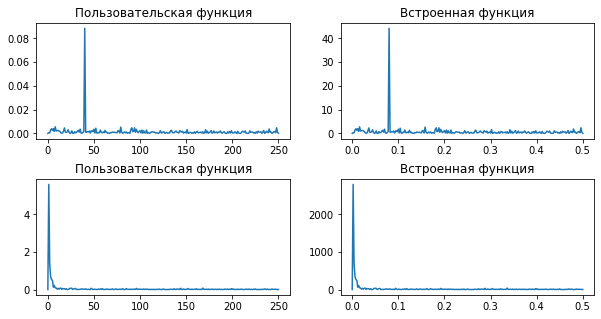

In [ ]:
def periodogram_(x):
    N = x.size
    size = N//2
    I = []
    m_x = x.mean()
    for i in range(size+1):
        _ = 2 * (np.sum((x - m_x) * np.cos(2 * np.pi * i * np.arange(N) / N))**2+\
            np.sum((x-m_x)*np.sin(2 * np.pi * i * np.arange(N) / N))**2) / N**2
        I.append(_)
    return np.arange(size+1), np.array(I)

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.35)
ax[0][0].plot(*periodogram_(y1))
ax[0][0].set_title('Пользовательская функция')
ax[0][1].plot(*periodogram(y1))
ax[0][1].set_title('Встроенная функция')
ax[1][0].plot(*periodogram_(y3))
ax[1][0].set_title('Пользовательская функция')
ax[1][1].plot(*periodogram(y3))
ax[1][1].set_title('Встроенная функция')

Text(0.5, 1.0, 'Спектральная Плотность Мощности')

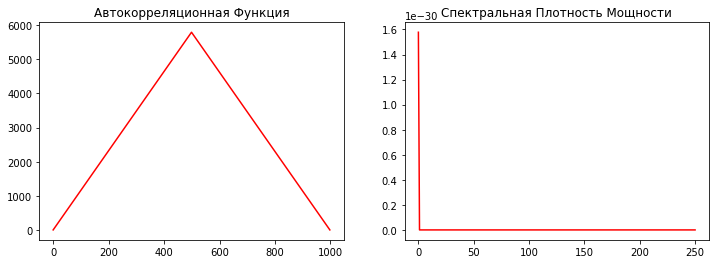

In [ ]:
a = np.array([3.4] * 500)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(auto_correlate(a), c='r')
ax[0].set_title('Автокорреляционная Функция')
ax[1].plot(*periodogram_(a), c='r')
ax[1].set_title('Спектральная Плотность Мощности')

Text(0.5, 1.0, 'Спектральная Плотность Мощности')

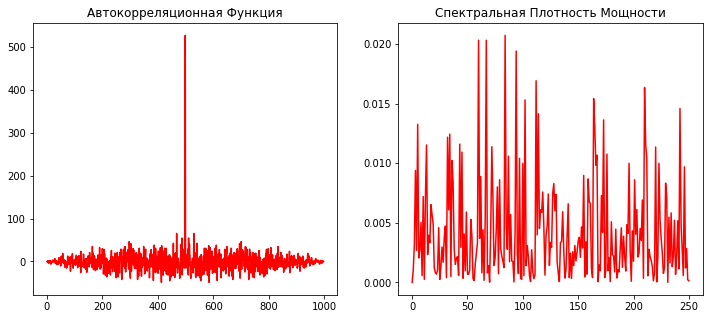

In [ ]:
b = np.random.normal(size=t.shape)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(auto_correlate(b), c='r')
ax[0].set_title('Автокорреляционная Функция')
ax[1].plot(*periodogram_(b), c='r')
ax[1].set_title('Спектральная Плотность Мощности')

Text(0.5, 1.0, 'СПМ')

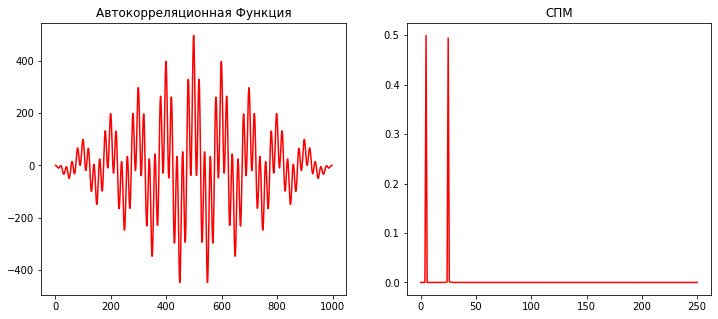

In [ ]:
c = np.sin(10 * np.pi * 5 * t) + np.sin(5 * np.pi * 2 * t)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(auto_correlate(c), c='r')
ax[0].set_title('Автокорреляционная Функция')
ax[1].plot(*periodogram_(c), c='r')
ax[1].set_title('СПМ')

Text(0.5, 1.0, 'Спектральная Плотность Мощности')

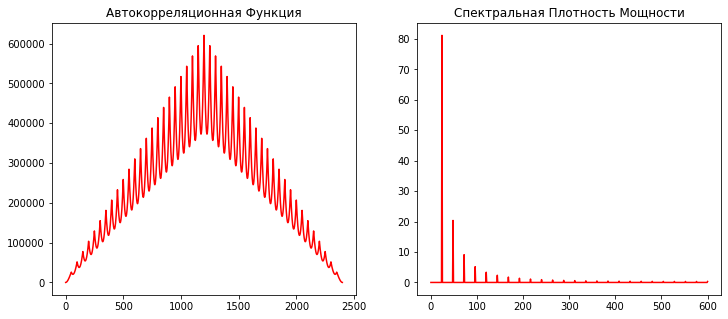

In [ ]:
d = np.array([_ * 0.8 for _ in range(50)] * 24)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(auto_correlate(d), c='r')
ax[0].set_title('Автокорреляционная Функция')
ax[1].plot(*periodogram_(d), c='r')
ax[1].set_title('Спектральная Плотность Мощности')

Text(0.5, 1.0, 'barthann')

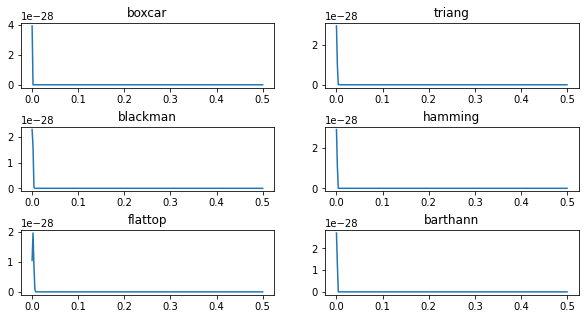

In [ ]:
# Пункт 6
fig, ax = plt.subplots(3, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.6)
ax[0][0].plot(*periodogram(a, window='boxcar'))
ax[0][0].set_title('boxcar')
ax[0][1].plot(*periodogram(a, window='triang'))
ax[0][1].set_title('triang')
ax[1][0].plot(*periodogram(a, window='blackman'))
ax[1][0].set_title('blackman')
ax[1][1].plot(*periodogram(a, window='hamming'))
ax[1][1].set_title('hamming')
ax[2][0].plot(*periodogram(a, window='flattop'))
ax[2][0].set_title('flattop')
ax[2][1].plot(*periodogram(a, window='barthann'))
ax[2][1].set_title('barthann')

Text(0.5, 1.0, 'barthann')

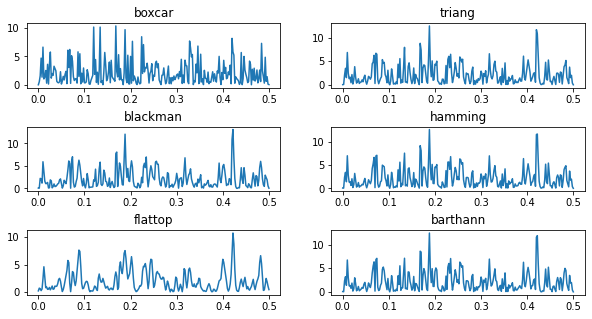

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.6)
ax[0][0].plot(*periodogram(b, window='boxcar'))
ax[0][0].set_title('boxcar')
ax[0][1].plot(*periodogram(b, window='triang'))
ax[0][1].set_title('triang')
ax[1][0].plot(*periodogram(b, window='blackman'))
ax[1][0].set_title('blackman')
ax[1][1].plot(*periodogram(b, window='hamming'))
ax[1][1].set_title('hamming')
ax[2][0].plot(*periodogram(b, window='flattop'))
ax[2][0].set_title('flattop')
ax[2][1].plot(*periodogram(b, window='barthann'))
ax[2][1].set_title('barthann')

Text(0.5, 1.0, 'barthann')

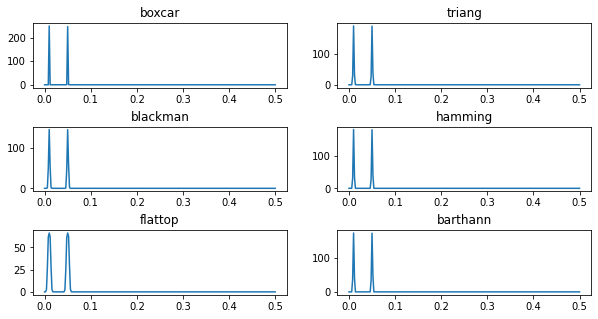

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.6)
ax[0][0].plot(*periodogram(c, window='boxcar'))
ax[0][0].set_title('boxcar')
ax[0][1].plot(*periodogram(c, window='triang'))
ax[0][1].set_title('triang')
ax[1][0].plot(*periodogram(c, window='blackman'))
ax[1][0].set_title('blackman')
ax[1][1].plot(*periodogram(c, window='hamming'))
ax[1][1].set_title('hamming')
ax[2][0].plot(*periodogram(c, window='flattop'))
ax[2][0].set_title('flattop')
ax[2][1].plot(*periodogram(c, window='barthann'))
ax[2][1].set_title('barthann')

Text(0.5, 1.0, 'barthann')

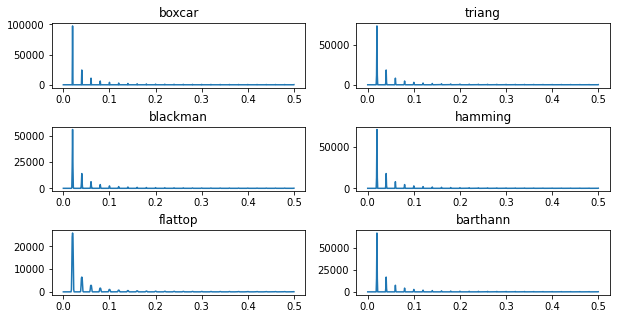

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.6)
ax[0][0].plot(*periodogram(d, window='boxcar'))
ax[0][0].set_title('boxcar')
ax[0][1].plot(*periodogram(d, window='triang'))
ax[0][1].set_title('triang')
ax[1][0].plot(*periodogram(d, window='blackman'))
ax[1][0].set_title('blackman')
ax[1][1].plot(*periodogram(d, window='hamming'))
ax[1][1].set_title('hamming')
ax[2][0].plot(*periodogram(d, window='flattop'))
ax[2][0].set_title('flattop')
ax[2][1].plot(*periodogram(d, window='barthann'))
ax[2][1].set_title('barthann')

In [ ]:
# Пункт 7
x = 2 * np.sin(102 * 2 * np.pi * t) + 1.7 * np.sin(102.08 * t * 2 * np.pi) +\
2.3 * np.sin(110 * t * 2 * np.pi) + 0.2 * np.random.normal(size=t.shape)

y = 1.6 * np.sin(102.8 * t * 2 * np.pi) + 2.1 * np.sin(110 * t * 2 * np.pi) +\
2 * np.sin(210 * t * 2 * np.pi) + 0.2 * np.random.normal(size=t.shape)

Text(0.5, 1.0, 'Взаимная спектральная плотность мощности ')

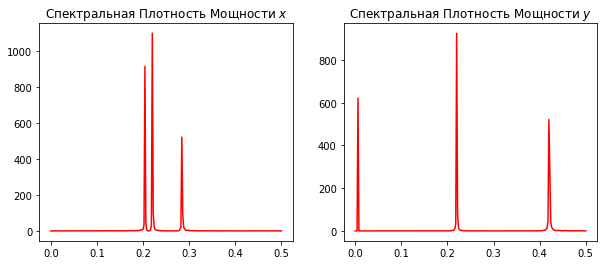

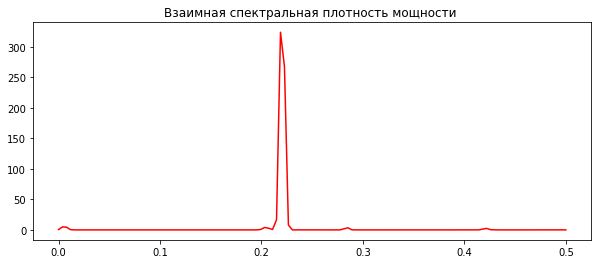

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(*periodogram(x), c='r')
ax[0].set_title('Cпектральная Плотность Мощности $x$')

ax[1].plot(*periodogram(y), c='r')
ax[1].set_title('Cпектральная Плотность Мощности $y$')
plt.figure(figsize=(10,4))
f, Pxy = csd(x,y)
plt.plot(f, np.abs(Pxy), c='r')
plt.title('Взаимная спектральная плотность мощности ')